In [3]:
%cd ..

/rds/user/jaf98/hpc-work/accelerate-md


In [4]:
import yaml
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from src.accelmd.samplers.pt.parallel_tempering import ParallelTempering
from src.accelmd.samplers.pt.dyn_wrapper import DynSamplerWrapper
from src.accelmd.targets.aldp.potential import AldpPotential
from src.accelmd.targets.aldp.cartesian import AldpPotentialCart
from src.accelmd.targets.gmm import GMM

IndentationError: expected an indented block after 'else' statement on line 67 (parallel_tempering.py, line 69)

In [3]:
import sys
print(sys.executable)

/home/jaf98/miniforge3/envs/accelmd/bin/python


In [4]:
# ─── Cell 1 ───
# (adjust this path so that `from main.targets.gmm import GMM` works)
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

from src.accelmd.targets.gmm import GMM


def create_gmm(dim=2, n_mixes=5, loc_scaling=2.0, device="cpu", seed=42):
    """Create a Gaussian Mixture Model with specified parameters."""
    torch.manual_seed(seed)
    return GMM(
        dim=dim,
        n_mixes=n_mixes,
        loc_scaling=loc_scaling,
        seed=seed,
        device=device
    )


def plot_gmm_contour(gmm, bounds=(-5, 5), resolution=100):
    """
    Create a simple contour plot of the GMM distribution.
    
    Args:
        gmm: The GMM distribution object
        bounds: The (min, max) bounds for both x and y axes
        resolution: Grid resolution for visualization
    """
    x = np.linspace(bounds[0], bounds[1], resolution)
    y = np.linspace(bounds[0], bounds[1], resolution)
    X, Y = np.meshgrid(x, y)

    points = np.column_stack([X.flatten(), Y.flatten()])
    points_tensor = torch.tensor(points, dtype=torch.float32, device=gmm.device)

    log_probs = gmm.log_prob(points_tensor).cpu().numpy()
    Z = np.exp(log_probs).reshape(X.shape)

    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(contour)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('GMM Contour Plot')
    
    return plt.gcf()

In [5]:
# ─── Cell 2 ───
# fixed globals for the wrapper
device     = "cuda" if torch.cuda.is_available() else "cpu"
_bounds    = (-5, 5)
_resolution= 100


def interactive_gmm(dim, n_mixes, loc_scaling):
    """
    Wrapper that only takes (dim, n_mixes, loc_scaling),
    so interact() won’t accidentally reassign `bounds` or `resolution`.
    """
    gmm = create_gmm(
        dim=dim,
        n_mixes=n_mixes,
        loc_scaling=loc_scaling,
        device=device
    )
    fig = plot_gmm_contour(gmm, bounds=_bounds, resolution=_resolution)
    plt.show()

In [6]:
# ─── Cell 3 ───
# finally—hook up the three sliders
interact(
    interactive_gmm,
    dim=IntSlider(min=2, max=5, step=1,   value=2, description="dim"),
    n_mixes=IntSlider(min=1, max=10, step=1,value=5, description="n_mixes"),
    loc_scaling=FloatSlider(min=0.1, max=10.0, step=0.1, value=2.0, description="loc_scaling")
)

interactive(children=(IntSlider(value=2, description='dim', max=5, min=2), IntSlider(value=5, description='n_m…

<function __main__.interactive_gmm(dim, n_mixes, loc_scaling)>

# Introduction
In this notebook, you could simulate samples with shape (num_temperature, num_chains, num_steps, dim) using **Parallel Tempering**.

For test, you can simulate a 40-mode Mixture of Gaussian in 2-dimensional space.

For Alanine Dipeptide (ALDP), You can either simulate either in: 
    1. internal coordinate, *i.e.* torsional angles etc, using AldpPotential; or 
    2. Cartesian coordinate, *i.e.* the 3D coordinate of each atom, using AldpPotentialCart


In [7]:
"""
Download the data first
"""
os.makedirs("data/", exist_ok=True)
os.makedirs("data/aldp/", exist_ok=True)

In [4]:
!wget -O data/pt/train.h5 "https://zenodo.org/records/6993124/files/train.h5?download=1"

--2025-06-10 10:16:15--  https://zenodo.org/records/6993124/files/train.h5?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220172366 (210M) [application/octet-stream]
Saving to: ‘data/pt/train.h5’

data/pt/train.h5    100%[===================>] 209.97M  32.5MB/s    in 5.9s    

2025-06-10 10:16:21 (35.7 MB/s) - ‘data/pt/train.h5’ saved [220172366/220172366]



## Set up your config
You need to set:
1. target distribution: "gmm"/"aldp_inter"/"aldp_cart"
2. temperature: 
    - schedule: "geom"/"linear"
    - max temperature
    - min temperature
    - num. of temperature
3. how many chains you want to run parallely. 
 - FYI: the "chain" here is totally different from "num. of temperature", it refers to how many copies of PT you want to run simultainously
4. (optional) Your wandb account, for logging metrics like swap rate. Please set your wandb in "configs/logger/wandb.yaml"

For simplicity, I didn't use yaml files in this toy notebook. But you could find different config in configs/pt

In [9]:
import wandb
wandb.init(project="accelerate-md")

wandb: Currently logged in as: jaf98 (jaf98-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [10]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = {
    "name": "gmm",  # gmm or aldp_inter or aldp_cart
    "temp_schedule": "geom",  # geom/linear, we usually use the geometrical schedule, but you could play
    "temp_low": 1.0,
    "temp_high": 100.,
    "total_n_temp": 10,
    "num_chains": 1,
    "num_steps": 1000, # number of steps for PT simulation
    "step_size": 0.0001, # step size of MCMC
    "swap_interval": 100, # how often to swap samples between different temperatures
    "check_interval": 10000,  # how many steps to evaluate the samples
    "plot_fold": "plots",  # set where you save the plots
    "save_fold": "results",  # set where you save the results
    "use_wandb": False,
    "device": device
}

## Set up

In [11]:
"""
Set up WandB
"""
if config["use_wandb"]:
    with open('configs/logger/wandb.yaml', 'r') as file:
        wandb_config = yaml.safe_load(file)

    wandb_config['tags'] = ['PT', config["name"]]
    wandb_config['group'] = config["name"]
    wandb.init(
        entity=wandb_config['entity'],
        project=wandb_config['project'],
        mode="online" if not wandb_config['offline'] else "offline",
        group=wandb_config['group'],
        tags=wandb_config['tags'],
        config=config
    )

In [12]:
"""
Set up temperatures
"""
if config["temp_schedule"] == 'geom':
    all_temps = torch.from_numpy(np.geomspace(config["temp_low"], config["temp_high"], config["total_n_temp"])).float().to(config["device"])
elif config["temp_schedule"] == 'linear':
    all_temps = torch.linspace(config["temp_low"], config["temp_high"], config["total_n_temp"]).float().to(config["device"])

In [13]:
"""
Set up target distribution
"""
if config["name"] == "gmm":
    dim = 2
    target = GMM(dim=dim, n_mixes=40, loc_scaling=40., log_var_scaling=1.0, seed=0, n_test_set_samples=1000, device=config["device"])

elif config["name"] == "aldp_inter":
    from src.accelmd.targets.aldp.potential import get_aldp_potential
    dim = 60
    aldp_config_path = "configs/aldp.yaml"
    target = get_aldp_potential(aldp_config_path, device=config["device"])

elif config["name"] == "aldp_cart":
    from src.accelmd.targets.aldp.cartesian import get_aldp_potential
    dim = 66
    aldp_config_path = "configs/aldp.yaml"
    target = get_aldp_potential(aldp_config_path, device=config["device"])
else:
    raise ValueError("Unknown target")

In [14]:
"""
Set up plot-saving path
"""
plot_path = f"{config['plot_fold']}/{config['name']}"
os.makedirs(config["plot_fold"], exist_ok=True)
os.makedirs(plot_path, exist_ok=True)

# PT Simulation

## 1. Choose the initial location to start running PT

In [15]:
if config["name"] == "aldp":
    init_position_file = yaml.safe_load(open(aldp_config_path, "r")).get("data", {}).get("transform")
    x_init = torch.load(init_position_file, map_location=config["device"])
    x_init = target.coordinate_transform.inverse(x_init)[0]
    x_init = x_init.unsqueeze(0).repeat(config["total_n_temp"], config["num_chains"], 1)
elif config["name"] == "aldp_cart":
    init_position_file = yaml.safe_load(open(aldp_config_path, "r")).get("data", {}).get("transform")
    x_init = torch.load(init_position_file, map_location=config["device"])
    x_init = x_init.unsqueeze(0).repeat(config["total_n_temp"], config["num_chains"], 1)
else:
    x_init = torch.randn((config["total_n_temp"], config["num_chains"], dim), device=config["device"])*0.01

## 2. Create the PT sampler object
The PT sampler object is then wrapped by the *DynSamplerWrapper*, which allows us to dynamically adjust the step size of MCMC at each temperature. The default setting is to make sure the acceptance rate of MH remains around 60%, and the hyperparameter *alpha* controls the strength of adjusting.

In [16]:
pt = ParallelTempering(x=x_init,
                       energy_func=lambda x: -target.log_prob(x),
                       step_size=torch.tensor([config["step_size"]] * (config["total_n_temp"] * config["num_chains"]), device=config["device"]).unsqueeze(-1),
                       swap_interval=config["swap_interval"],
                       temperatures=all_temps,
                       mh=True,
                       device=config["device"])
pt = DynSamplerWrapper(pt, per_temp=True, total_n_temp=config["total_n_temp"], target_acceptance_rate=0.6, alpha=0.25)
progress_bar = tqdm(range(config["num_steps"]), desc="Parallel Tempering")
swap_rates = []
traj = []
for i in progress_bar:
    """
    The following two lines are almost all you need for sampling from PT
    """
    new_samples, acc, *_ = pt.sample()
    traj.append(new_samples.clone().detach().cpu().float())

    """
    The following codes are logging useful information
    """
    if pt.sampler.swap_rates:
        swap_rates.append(pt.sampler.swap_rates)
        if wandb.run is not None:
            for j in range(len(all_temps) - 1):
                wandb.log({f"swap_rates/{all_temps[j].item():.2f}~{all_temps[j + 1].item():.2f}": pt.sampler.swap_rates[j]}, step=i)
    if (i + 1) % config["check_interval"] == 0:
        os.makedirs(config["save_fold"], exist_ok=True)
        torch.save(torch.stack(traj, dim=2)[0].detach().cpu().float(), f"{config['save_fold']}/pt_{config['name']}.pt")
        if isinstance(target, AldpPotential) or isinstance(target, AldpPotentialCart):
            sub_plot_path = f"{plot_path}/{i + 1}"
            os.makedirs(sub_plot_path, exist_ok=True)
            images_dict = target.plot_samples(torch.stack(traj[-config["check_interval"]:], dim=2)[0].reshape(-1, dim).to(config["device"]), target.sample(1000000), i, sub_plot_path, sub_plot_path, 1000000)
            if wandb.run is not None:
                for key, value in images_dict.items():
                    wandb.log({f"{key}": wandb.Image(value)}, step=i)
        else:
            plt.figure(figsize=(6, 6))
            target.plot_samples(samples_list=[torch.stack(traj[-config["check_interval"]:], dim=2)[0].reshape(-1, dim),
                                            target.sample([config["check_interval"]])],
                                labels_list=["pt", "gt"],
                                alpha=0.5,)
            plt.legend()
            if wandb.run is not None:
                wandb.log({"samples": wandb.Image(plt)}, step=i)
            plt.close()
    if wandb.run is not None:
        for j in range(len(all_temps)):
            wandb.log({f"acc_rates/{all_temps[j].item():.2f}": acc[j].item()}, step=i)
    progress_bar.set_postfix_str(f"acc rate: {acc.mean().item()}")
traj = torch.stack(traj, dim=2)
os.makedirs(config["save_fold"], exist_ok=True)
torch.save(traj.detach().cpu().float(), f"{config['save_fold']}/pt_{config['name']}.pt")

Parallel Tempering:   0%|          | 0/1000 [00:00<?, ?it/s]/rds/user/jaf98/hpc-work/accelerate-md/src/accelmd/samplers/mcmc/langevin.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_p = x_c - self.step_size * grad_xc + torch.sqrt(torch.tensor(2.0*self.step_size, device=self.device)) * torch.randn_like(self.x, device=self.device)
Parallel Tempering:   4%|▍         | 44/1000 [00:00<00:04, 217.66it/s, acc rate: 0.901674747467041] 

Parallel Tempering: 100%|██████████| 1000/1000 [00:04<00:00, 233.49it/s, acc rate: 0.509364128112793] 


## Example evaluation for GMM
Run the following codes for visualization of samples from PT if you are sampling from Mixture of Gaussian

In [17]:
traj.shape

torch.Size([10, 1, 1000, 2])

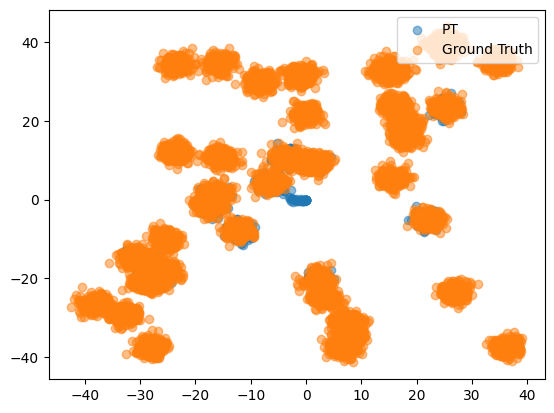

In [18]:
true_samples = target.sample((10000,))
pt_samples = traj[0, 0, :, :]
plt.figure()
plt.scatter(pt_samples[:, 0].detach().cpu().numpy(), pt_samples[:, 1].detach().cpu().numpy(), alpha=0.5, label="PT")
plt.scatter(true_samples[:, 0].detach().cpu().numpy(), true_samples[:, 1].detach().cpu().numpy(), alpha=0.5, label="Ground Truth")
plt.legend(loc="upper right")
plt.show()